<a href="https://colab.research.google.com/github/reznimat/ppzd_sp/blob/main/semestralni_prace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analýza prodejů fiktivního online obchodu.

Autor: **Matěj Řezníček**, KIV-FAV-ZČU

Email: reznicek.mat@gmail.com

Datum: **1.5.2024**

## Cíl práce

* KPI ukazatele
* korelace marketingových výdajů a hrubých výnosů
* Návrh možné segmentace klientů pro budoucí cílené kampaně

## Data

### Vstupní soubory

Vstupními soubory pro analýzu jsou volně dostupné .csv a .xlsx soubory získané na platformě Kaggle.com - konkrétně dataset [Marketing Insights for E-Commerce company](https://www.kaggle.com/datasets/rishikumarrajvansh/marketing-insights-for-e-commerce-company?select=Online_Sales.csv).

Všechny soubory byly před použitím v semestrální práci převedeny do formátu .csv a uloženy na [GitHub](https://github.com/reznimat/ppzd_sp)

**Jednotlivé vstupní soubory pro tuto semestrální práci:**
* **Online_Sales.csv** - soubor obsahuje data o prodejcíh s granularitou na  prodanou položku.
    * CustomerID: unikátní identifikátor zákazníka
    * Transaction_ID: unikátní identifikátor transakce
    * Transaction_Date: datum uskutečnění transakce
    * Product_SKU: SKU ID – unikátní identifikátor produktu
    * Product_Description: popis produktu
    * Product_Cateogry: kategorie produktu
    * Quantity: počet objednaných kusů
    * Avg_Price: kusová cena
    * Delivery_Charges: náklady na dopravu
    * Coupon_Status: Příznak, zda byla uplatněna sleva

  Poznámky:
    * Data o prodejích jsou od 1.1.2019 do 31.12.2019
    * Některé transakce mají vazbu na více zákazníků
    * Náklady na dopravu působí jako celkový náklad an dopravu objednávky, cena je však duplikována na všech položkách dané objednávky
    * Coupon Status nabývá hodnot Clicked, Used a Not Used. Pro obě hodnoty Clicked a Used uvažuji, že byla uplatněna stejná sleva, liší se pouze formou zadání kupónu do objednávky.

* **Discount_Coupon.csv** - soubor obsahuje čísleník slev pro každý měsíc a produktovou kategorii. Každá kombinace měsíce a kategorie se v číselníku objevuje maximálně 1x.
    * Month - měsíc ve kterém odpovídající sleva platí - uloženo ve formátu "Jan"
    * Product_Category - produktová kategorie pro kterou daná sleva platí
    * Coupon_Code - kód kupónu pro daný měsíc a kategorii
    * Discount_pct - Výše slevy po uplatnění kupónu pro danou kategorii v daném měsíci v procentních bodech (10,20,30)
* **Marketing_Spend.csv** - soubor obsahuje náklady na online a offline marketing pro jednotlivé dny seldovaného období
    * Date - datum
    * Offline_Spend - Náklady na offline marketing (TV, Radio, apod.)
    * Online_Spend - Náklady na online marketing (Google, Facebook, apod.)

* **CustomersData.csv** - soubor obsahuje demografické údaje o zákaznících obchodu.
    * CustomerID - jedinečný identifikátor zákazníka
    * Gender - pohlaví zákazníka
    * Location - Geolokace zákazníka
    * Tenure_Months - Doba jak dlouho je zákazník zákazníkem v měsících
  
  Poznámky: Tento soubor jsem použil pouze jako zdroj unikátních identifikátorů zákazníků a více jsem s ním nepracoval.


### Načtení vstupních souborů

In [3]:
# načtení knihovy pnadas pro práci s datovými soubory
import pandas as pd

#načtení souboru Online_Sales.csv
url_sales = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Online_Sales.csv'
df_sales = pd.read_csv(url_sales)
# převod textu na datum
df_sales['Transaction_Date'] = pd.to_datetime(df_sales['Transaction_Date'],format='%m/%d/%Y')

# Načtení souboru Discount_Coupon.csv
url_coupons = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Discount_Coupon.csv'
df_coupons = pd.read_csv(url_coupons,delimiter=";")

# Načtení souboru Marketing_Spend.csv
url_marketing = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Marketing_Spend.csv'
df_marketing = pd.read_csv(url_marketing,delimiter=";")
#převod textu na datum
df_marketing['Date'] = pd.to_datetime(df_marketing['Date'],format='%m/%d/%Y')

# Načtení soubou CustomerData
url_customer = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/CustomersData.csv'
df_customer = pd.read_csv(url_customer,delimiter=";")


#print(df_sales.head().info())
#print(df_marketing.info())

print('vstupní soubory načteny')

vstupní soubory načteny


## Výpočet KPI


### Výpočet hurbého výnosu
- Revenue = (Quantity x Avg_price) x (1-Dicount_pct)

#### Obohacení df_sales o atribut Month (Date Abrv)
Pro rozšíření souboru df_sales o uplatněnou slevu je potřeba přiřadit každému řádku hodnotu odpovídající měsíci, v němž byla transakce uskutečněna ve formátu date abbrevation, tedy Jan apod.

In [4]:
#rozšíření DataFrame df_sales o nový atribut Month a přiřazení month abbrevation hodnoty na základě data Transaction_Date do tohoto sloupce
df_sales['Month'] = df_sales['Transaction_Date'].dt.strftime('%b')

print('v df_sales je nyní sloupec Month\n')
print(df_sales.tail().to_markdown())


v df_sales je nyní sloupec Month

|       |   CustomerID |   Transaction_ID | Transaction_Date    | Product_SKU    | Product_Description                             | Product_Category   |   Quantity |   Avg_Price |   Delivery_Charges | Coupon_Status   | Month   |
|------:|-------------:|-----------------:|:--------------------|:---------------|:------------------------------------------------|:-------------------|-----------:|------------:|-------------------:|:----------------|:--------|
| 52919 |        14410 |            48493 | 2019-12-31 00:00:00 | GGOENEBB078899 | Nest Cam Indoor Security Camera - USA           | Nest-USA           |          1 |      121.3  |               6.5  | Clicked         | Dec     |
| 52920 |        14410 |            48494 | 2019-12-31 00:00:00 | GGOEGAEB091117 | Google Zip Hoodie Black                         | Apparel            |          1 |       48.92 |               6.5  | Used            | Dec     |
| 52921 |        14410 |            48495 | 20

#### Spojení df_sales s df_coupons

Merge Data Framů df_sales a df_coupons na základě shody měsíce a produktové kategorie v Data frametransakcí a data framu kuponů

In [5]:
#Merge Sales a Coupons na základě Product_Category a Month
# how = left, aby nedošlo ke ztrátě řádků v případě, že daný měsíc a produktová kategorie nebude v čísleníku slevových kuponů
df_sales_coupons = pd.merge(df_sales,df_coupons, how='left', on=["Product_Category","Month"])

print('do df_sales byly připojeny data z df_coupons\n')
print(df_sales_coupons.tail().to_markdown())

do df_sales byly připojeny data z df_coupons

|       |   CustomerID |   Transaction_ID | Transaction_Date    | Product_SKU    | Product_Description                             | Product_Category   |   Quantity |   Avg_Price |   Delivery_Charges | Coupon_Status   | Month   | Coupon_Code   |   Discount_pct |
|------:|-------------:|-----------------:|:--------------------|:---------------|:------------------------------------------------|:-------------------|-----------:|------------:|-------------------:|:----------------|:--------|:--------------|---------------:|
| 52919 |        14410 |            48493 | 2019-12-31 00:00:00 | GGOENEBB078899 | Nest Cam Indoor Security Camera - USA           | Nest-USA           |          1 |      121.3  |               6.5  | Clicked         | Dec     | ELEC30        |             30 |
| 52920 |        14410 |            48494 | 2019-12-31 00:00:00 | GGOEGAEB091117 | Google Zip Hoodie Black                         | Apparel            |          1 

#### Výpočet Revenue na úrovni jednotlivých pložek

In [6]:
# definice funkce pro výpočet Revenue po slevě na úrovni položky
# pokud coupon_status = not_used nebo není k dispozici pro daný měsíc a kategorii info o slevě, počítá revenue pouze jako součin počtu kusů a jednotkové ceny. Jinak zohledňuje i slevu pro danou položku
def Revenue(row):
    if row["Coupon_Status"] == 'Not Used' or pd.isna(row["Discount_pct"]):
      return (row["Quantity"]*row["Avg_Price"])
    else:
      return (row["Quantity"]*row["Avg_Price"])*(1-(row["Discount_pct"]/100))

# vytvoření nového data_frame pro pozdější práci s výnosy
df_item_revenue = df_sales_coupons

# zahození Data Frmae df_sales_coupons, již není potřeba
del df_sales_coupons

# rozšíření Data Frame df_item_revenue o atribut Revenue naplněný vypočtenou hodnotu pomocí výše definované funkce
df_item_revenue["Revenue"] = df_item_revenue.apply(Revenue,axis = 1)

print('df_item_revenue bylo rozšířeno o sloupec Revenue\n')
print(df_item_revenue.info())

df_item_revenue bylo rozšířeno o sloupec Revenue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  int64         
 1   Transaction_ID       52924 non-null  int64         
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
 10  Month                52924 non-null  object        
 11  Coupon_Code          52524 non-null  object        
 12  Discount_pct         52524 non-null  f

#### Výpočet Revenue na úrovni transakcí


In [7]:
# Vytvoření seznamu jedinečných ID transakcí z Data Frame df_sales
c_transaction = set()
for i, row in df_sales.iterrows():
  c_transaction.add((row["Transaction_ID"], row['Transaction_Date']))

# Vyprázdnění pracovního listu pro ukládání jedinečných záznamů o transakcích se součtem položkových výnosů
work_list = []

# pro každou transakci v seznamu jedinečných transakcí c_transaction udělá sumu všech položkových revenues a záznam ulžoží do listu work_list
for Transaction, Date  in c_transaction:
      filtered_df = df_item_revenue[(df_item_revenue['Transaction_ID'] == Transaction)]
      Revenue = filtered_df['Revenue'].sum()
      work_list.append((Transaction, Date, Revenue))

# převod listu na data_frame
df_transaction_revenue = pd.DataFrame.from_records(work_list, columns=[ 'Transaction_ID', 'Transaction_Date', 'Revenue'])

print(df_transaction_revenue.head().to_markdown())

|    |   Transaction_ID | Transaction_Date    |   Revenue |
|---:|-----------------:|:--------------------|----------:|
|  0 |            27474 | 2019-05-08 00:00:00 |    28.784 |
|  1 |            19299 | 2019-01-31 00:00:00 |   509.166 |
|  2 |            28577 | 2019-05-21 00:00:00 |    25.08  |
|  3 |            23118 | 2019-03-17 00:00:00 |   119     |
|  4 |            46306 | 2019-12-10 00:00:00 |    78.277 |


### Výpočet a graf výnosů po měsících

#### Výpočet

In [8]:
# Vytvoření číselníku měsíců (zejména kvůli řazení)
c_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

work_list = []

for month in c_months:
  filtered_df = df_item_revenue[(df_item_revenue['Month'] == month)]
  sum_of_sales = filtered_df['Revenue'].sum()
  number_of_orders = filtered_df['Transaction_ID'].nunique()
  number_of_customers = filtered_df['CustomerID'].nunique()
  work_list.append((month,number_of_customers, number_of_orders, sum_of_sales))

df_monthly_KPI = pd.DataFrame.from_records(work_list, columns=['Month','Customers', 'Orders', 'Revenue']) # převod listu na data_frame

df_monthly_KPI['AOV'] = df_monthly_KPI['Revenue'] / df_monthly_KPI['Orders']
df_monthly_KPI['AvgOrderCount'] = df_monthly_KPI['Orders'] / df_monthly_KPI['Customers']


print(df_monthly_KPI.to_markdown())

|    | Month   |   Customers |   Orders |   Revenue |     AOV |   AvgOrderCount |
|---:|:--------|------------:|---------:|----------:|--------:|----------------:|
|  0 | Jan     |         215 |     2102 |    369449 | 175.761 |         9.77674 |
|  1 | Feb     |         109 |     1664 |    259129 | 155.726 |        15.2661  |
|  2 | Mar     |         208 |     1991 |    263183 | 132.186 |         9.57212 |
|  3 | Apr     |         224 |     1813 |    367774 | 202.854 |         8.09375 |
|  4 | May     |         200 |     2034 |    256218 | 125.967 |        10.17    |
|  5 | Jun     |         259 |     1940 |    242392 | 124.944 |         7.49035 |
|  6 | Jul     |         236 |     2080 |    341701 | 164.279 |         8.81356 |
|  7 | Aug     |         300 |     2414 |    333758 | 138.26  |         8.04667 |
|  8 | Sep     |         193 |     1932 |    269053 | 139.261 |        10.0104  |
|  9 | Oct     |         210 |     2125 |    374946 | 176.445 |        10.119   |
| 10 | Nov     |

#### Grafy

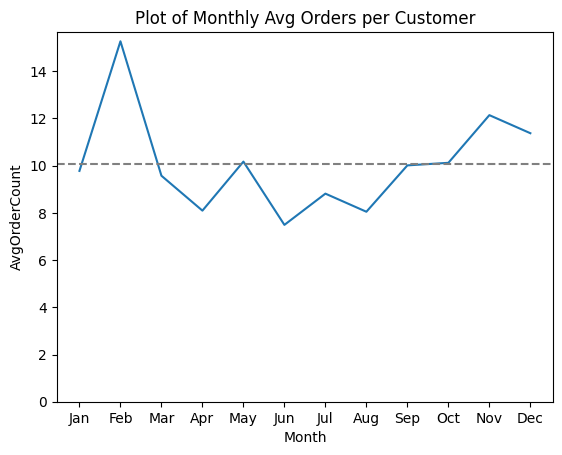

In [9]:
from matplotlib import pyplot as plt

mean_value = df_monthly_KPI['AvgOrderCount'].mean()


# Create plot (replace with your desired plot type)
plt.plot(df_monthly_KPI["Month"], df_monthly_KPI["AvgOrderCount"])
plt.axhline(y=mean_value, color='grey', linestyle='dashed', label='Mean')
plt.xlabel('Month')
plt.ylabel('AvgOrderCount')
plt.title('Plot of Monthly Avg Orders per Customer')
plt.ylim(bottom=0) # y začíná na 0
plt.show()

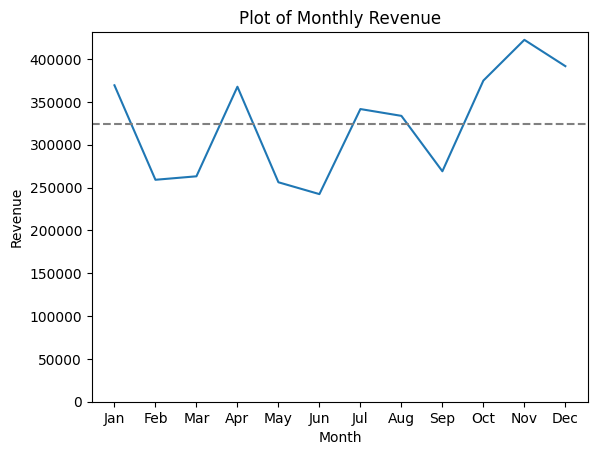

In [10]:
from matplotlib import pyplot as plt

mean_value = df_monthly_KPI['Revenue'].mean()


# Create plot (replace with your desired plot type)
plt.plot(df_monthly_KPI["Month"], df_monthly_KPI["Revenue"])
plt.axhline(y=mean_value, color='grey', linestyle='dashed', label='Mean')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Plot of Monthly Revenue')
plt.ylim(bottom=0) # y začíná na 0
plt.show()

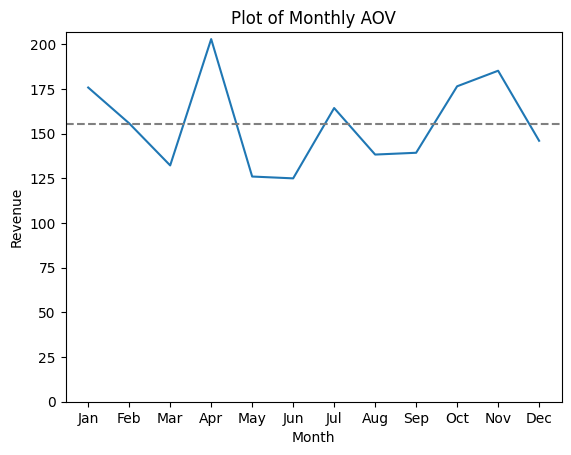

In [11]:
from matplotlib import pyplot as plt

mean_value = df_monthly_KPI['AOV'].mean()


# Create plot (replace with your desired plot type)
plt.plot(df_monthly_KPI["Month"], df_monthly_KPI["AOV"])
plt.axhline(y=mean_value, color='grey', linestyle='dashed', label='Mean')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Plot of Monthly AOV')
plt.ylim(bottom=0) # y začíná na 0
plt.show()

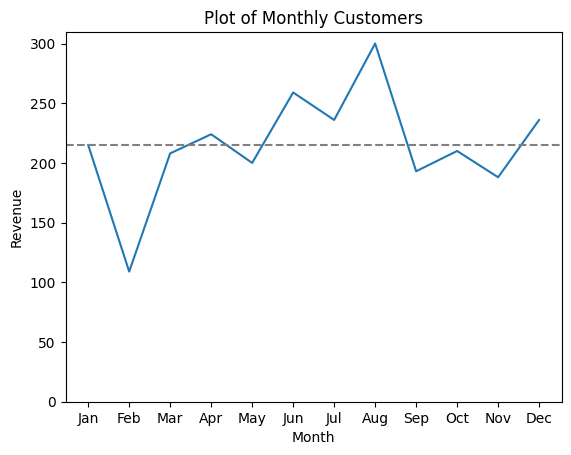

In [12]:
from matplotlib import pyplot as plt

mean_value = df_monthly_KPI['Customers'].mean()

# Create plot (replace with your desired plot type)
plt.plot(df_monthly_KPI["Month"], df_monthly_KPI["Customers"])
plt.axhline(y=mean_value, color='grey', linestyle='dashed', label='Mean')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Plot of Monthly Customers')
plt.ylim(bottom=0) # y začíná na 0
plt.show()

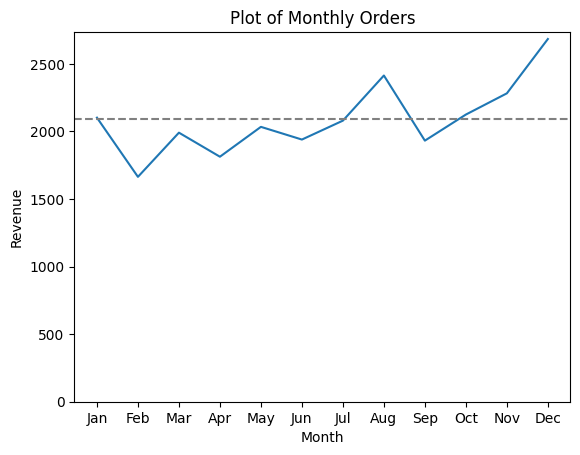

In [13]:
from matplotlib import pyplot as plt

mean_value = df_monthly_KPI['Orders'].mean()

# Create plot (replace with your desired plot type)
plt.plot(df_monthly_KPI["Month"], df_monthly_KPI["Orders"])
plt.axhline(y=mean_value, color='grey', linestyle='dashed', label='Mean')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Plot of Monthly Orders')
plt.ylim(bottom=0) # y začíná na 0
plt.show()

## Připojení souboru s marketingovými náklady k df_MonthSales

In [14]:
# přidání Month sloupce do df_marketing
df_marketing['Month'] = df_marketing['Date'].dt.strftime('%b')

# přidání celkového nákladu na marketing do df_marketing
df_marketing['Total_Spend'] = df_marketing['Offline_Spend']+df_marketing['Online_Spend']

print(df_marketing.head().to_markdown())

|    | Date                |   Offline_Spend |   Online_Spend | Month   |   Total_Spend |
|---:|:--------------------|----------------:|---------------:|:--------|--------------:|
|  0 | 2019-01-01 00:00:00 |            4500 |        2424.5  | Jan     |       6924.5  |
|  1 | 2019-01-02 00:00:00 |            4500 |        3480.36 | Jan     |       7980.36 |
|  2 | 2019-01-03 00:00:00 |            4500 |        1576.38 | Jan     |       6076.38 |
|  3 | 2019-01-04 00:00:00 |            4500 |        2928.55 | Jan     |       7428.55 |
|  4 | 2019-01-05 00:00:00 |            4500 |        4055.3  | Jan     |       8555.3  |


In [15]:
work_list = []

for  month in c_months:
  filtered_df = df_marketing[(df_marketing['Month'] == month)]
  sum_online = filtered_df['Online_Spend'].sum()
  sum_offline = filtered_df['Offline_Spend'].sum()
  sum_total = filtered_df['Total_Spend'].sum()
  work_list.append((month, sum_online, sum_offline, sum_total))

df_monthly_marketing = pd.DataFrame.from_records(work_list, columns=['Month', 'Online_Spend', 'Offline_Spend','Total_Spend']) # převod listu na data_frame

print(df_monthly_marketing.to_markdown())

|    | Month   |   Online_Spend |   Offline_Spend |   Total_Spend |
|---:|:--------|---------------:|----------------:|--------------:|
|  0 | Jan     |        58329   |           96600 |        154929 |
|  1 | Feb     |        55807.9 |           81300 |        137108 |
|  2 | Mar     |        48750.1 |           73500 |        122250 |
|  3 | Apr     |        61026.8 |           96000 |        157027 |
|  4 | May     |        52759.6 |           65500 |        118260 |
|  5 | Jun     |        53818.1 |           80500 |        134318 |
|  6 | Jul     |        52717.8 |           67500 |        120218 |
|  7 | Aug     |        57404.1 |           85500 |        142904 |
|  8 | Sep     |        52514.5 |           83000 |        135515 |
|  9 | Oct     |        57724.6 |           93500 |        151225 |
| 10 | Nov     |        68145   |           93000 |        161145 |
| 11 | Dec     |        76648.8 |          122000 |        198649 |


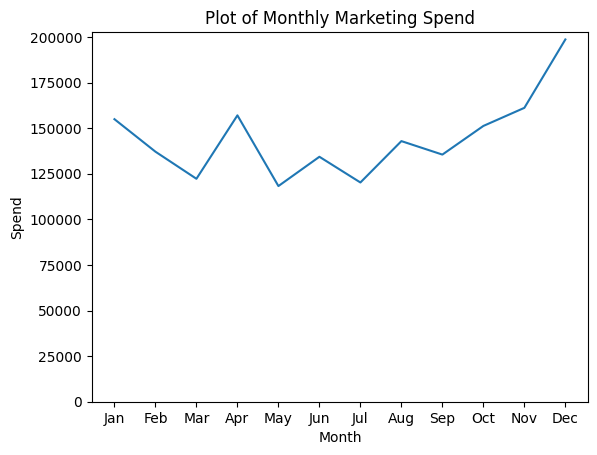

In [16]:
# Create plot (replace with your desired plot type)
plt.plot(df_monthly_marketing["Month"], df_monthly_marketing["Total_Spend"])
plt.xlabel('Month')
plt.ylabel('Spend')
plt.title('Plot of Monthly Marketing Spend')
plt.ylim(bottom=0) # y začíná na 0
plt.show()

# Spojit mothly sales a monthly marketing spend do jednoho df a grafu

In [17]:
#Merge Sales a Tax na základe Product_Category
df_KPI_marketing = pd.merge(df_monthly_KPI,df_monthly_marketing, on=["Month"])
df_KPI_marketing['Revenue_pct'] = df_KPI_marketing['Total_Spend']/df_KPI_marketing['Revenue']

print(df_KPI_marketing.to_markdown())

|    | Month   |   Customers |   Orders |   Revenue |     AOV |   AvgOrderCount |   Online_Spend |   Offline_Spend |   Total_Spend |   Revenue_pct |
|---:|:--------|------------:|---------:|----------:|--------:|----------------:|---------------:|----------------:|--------------:|--------------:|
|  0 | Jan     |         215 |     2102 |    369449 | 175.761 |         9.77674 |        58329   |           96600 |        154929 |      0.419352 |
|  1 | Feb     |         109 |     1664 |    259129 | 155.726 |        15.2661  |        55807.9 |           81300 |        137108 |      0.529111 |
|  2 | Mar     |         208 |     1991 |    263183 | 132.186 |         9.57212 |        48750.1 |           73500 |        122250 |      0.464507 |
|  3 | Apr     |         224 |     1813 |    367774 | 202.854 |         8.09375 |        61026.8 |           96000 |        157027 |      0.426965 |
|  4 | May     |         200 |     2034 |    256218 | 125.967 |        10.17    |        52759.6 |        

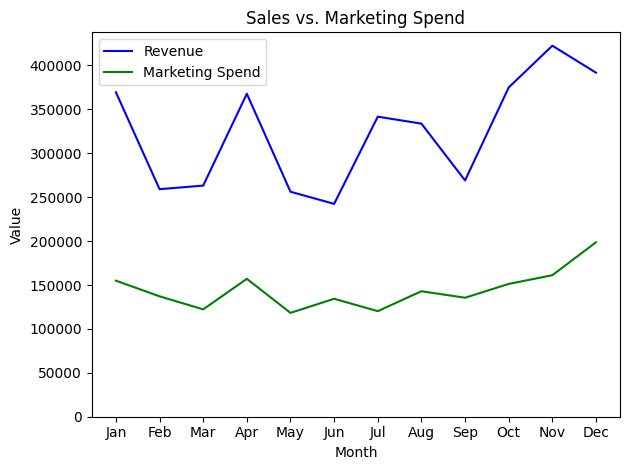

In [18]:
# Plot the first line (Sales)
plt.plot(df_KPI_marketing['Month'], df_KPI_marketing['Revenue'], label='Revenue', color='b')
plt.plot(df_KPI_marketing['Month'], df_KPI_marketing['Total_Spend'], label='Marketing Spend', color='g')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Sales vs. Marketing Spend')

# Add legend to distinguish lines
plt.legend()

# Optional: Customize gridlines and axes
#plt.grid(True, linestyle='--', linewidth=0.5)  # Add gridlines with style and width

plt.tight_layout()  # Adjust spacing between elements
plt.ylim(bottom=0) # y začíná na 0
plt.show()

Výpočet korelačních koeficientů pro jednotlivé KPIs a marketing spend

Size of Correlation	Interpretation
* .90 to 1.00 (−.90 to −1.00)	Very high positive (negative) correlation
* .70 to .90 (−.70 to −.90)	High positive (negative) correlation
* .50 to .70 (−.50 to −.70)	Moderate positive (negative) correlation
* .30 to .50 (−.30 to −.50)	Low positive (negative) correlation
* .00 to .30 (.00 to −.30)	negligible correlation

In [19]:
Revenue_corr = df_KPI_marketing['Revenue'].corr(df_KPI_marketing['Total_Spend'])
AOV_corr = df_KPI_marketing['AOV'].corr(df_KPI_marketing['Total_Spend'])
Customers_corr = df_KPI_marketing['Customers'].corr(df_KPI_marketing['Total_Spend'])
Orders_corr = df_KPI_marketing['Orders'].corr(df_KPI_marketing['Total_Spend'])

Revenue_corr_on = df_KPI_marketing['Revenue'].corr(df_KPI_marketing['Online_Spend'])
AOV_corr_on = df_KPI_marketing['AOV'].corr(df_KPI_marketing['Online_Spend'])
Customers_corr_on = df_KPI_marketing['Customers'].corr(df_KPI_marketing['Online_Spend'])
Orders_corr_on = df_KPI_marketing['Orders'].corr(df_KPI_marketing['Online_Spend'])

Revenue_corr_off = df_KPI_marketing['Revenue'].corr(df_KPI_marketing['Offline_Spend'])
AOV_corr_off = df_KPI_marketing['AOV'].corr(df_KPI_marketing['Offline_Spend'])
Customers_corr_off = df_KPI_marketing['Customers'].corr(df_KPI_marketing['Offline_Spend'])
Orders_corr_off = df_KPI_marketing['Orders'].corr(df_KPI_marketing['Offline_Spend'])


print('TOTAL SPEND\n-----------')
print("Revenue correlation coefficient:", Revenue_corr)
print("AOV Correlation coefficient:", AOV_corr)
print("Customers Correlation coefficient:", Customers_corr)
print("Orders Correlation coefficient:", Orders_corr)
print('\nONLINE SPEND\n-----------')
print("Revenue Correlation coefficient:", Revenue_corr_on)
print("AOV Correlation coefficient:", AOV_corr_on)
print("Customers Correlation coefficient:", Customers_corr_on)
print("Orders Correlation coefficient:", Orders_corr_on)
print('\nOFFLINE SPEND\n-----------')
print("Revenue Correlation coefficient:", Revenue_corr_off)
print("AOV Correlation coefficient:", AOV_corr_off)
print("Customers Correlation coefficient:", Customers_corr_off)
print("Orders Correlation coefficient:", Orders_corr_off)

TOTAL SPEND
-----------
Revenue correlation coefficient: 0.7199056207669227
AOV Correlation coefficient: 0.39805951874244916
Customers Correlation coefficient: 0.10698979154385156
Orders Correlation coefficient: 0.6216362412848978

ONLINE SPEND
-----------
Revenue Correlation coefficient: 0.7505015588785988
AOV Correlation coefficient: 0.3810967468607611
Customers Correlation coefficient: 0.07683383728490027
Orders Correlation coefficient: 0.6793278118381119

OFFLINE SPEND
-----------
Revenue Correlation coefficient: 0.6752182892221238
AOV Correlation coefficient: 0.3903679337022759
Customers Correlation coefficient: 0.1177792810838633
Orders Correlation coefficient: 0.5673414152998921


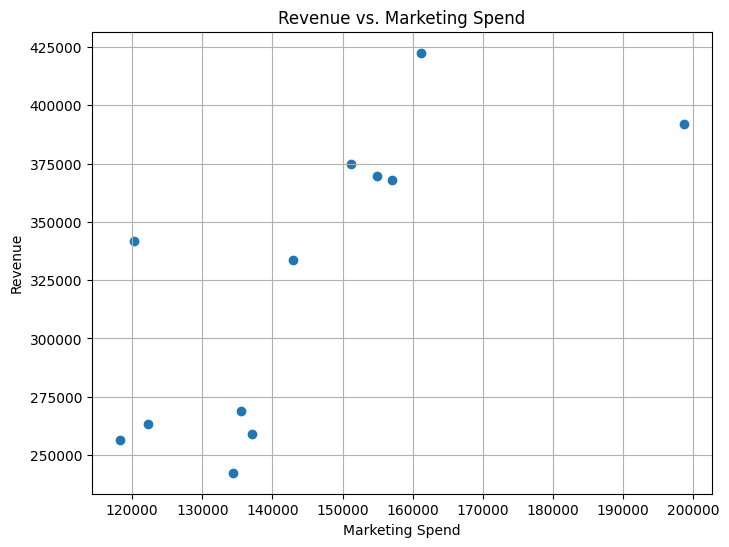

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(df_KPI_marketing['Total_Spend'], df_KPI_marketing['Revenue'])
plt.xlabel('Marketing Spend')
plt.ylabel('Revenue')
plt.title('Revenue vs. Marketing Spend')
plt.grid(True)
# plt.ylim(bottom=0) # y začíná na 0
# plt.xlim(left=0) # x začíná na 0
plt.show()

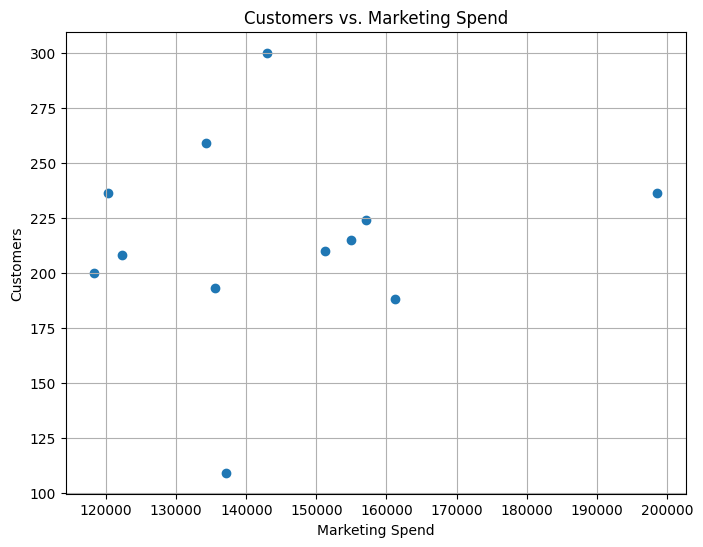

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(df_KPI_marketing['Total_Spend'], df_KPI_marketing['Customers'])
plt.xlabel('Marketing Spend')
plt.ylabel('Customers')
plt.title('Customers vs. Marketing Spend')
plt.grid(True)
# plt.ylim(bottom=0) # y začíná na 0
# plt.xlim(left=0) # x začíná na 0
plt.show()

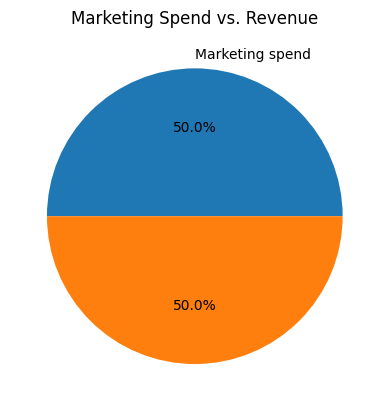

In [22]:
# Calculate average marketing spend percentage
average_marketing_spend = df_KPI_marketing["Revenue_pct"].mean()

# Prepare pie chart data
pie_data = [average_marketing_spend, average_marketing_spend]
pie_labels = ["Marketing spend".format(average_marketing_spend),'']

# Create the pie chart
plt.pie(pie_data, labels=pie_labels, autopct="%1.1f%%")
plt.title("Marketing Spend vs. Revenue")
plt.show()

# RFM (Recency, Frequency, Monetary)

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer. The raw data for doing this, which should be readily available in the company’s CRM or transactional databases, can be compiled in an Excel spreadsheet or database:

    Recency is simply the amount of time since the customer’s most recent transaction (most businesses use days, though for others it might make sense to use months, weeks or even hours instead).
    Frequency is the total number of transactions made by the customer (during a defined period).
    Monetary is the total amount that the customer has spent across all transactions (during a defined period).


In [23]:
df_item_revenue['Transaction_Date'] = pd.to_datetime(df_item_revenue['Transaction_Date'],format='%m/%d/%Y')
df_item_revenue['days_since_transaction'] = (pd.to_datetime('12/31/2019',format='%m/%d/%Y')-df_item_revenue['Transaction_Date']).dt.days

print(df_item_revenue.head().to_markdown())

|    |   CustomerID |   Transaction_ID | Transaction_Date    | Product_SKU    | Product_Description                                    | Product_Category   |   Quantity |   Avg_Price |   Delivery_Charges | Coupon_Status   | Month   | Coupon_Code   |   Discount_pct |   Revenue |   days_since_transaction |
|---:|-------------:|-----------------:|:--------------------|:---------------|:-------------------------------------------------------|:-------------------|-----------:|------------:|-------------------:|:----------------|:--------|:--------------|---------------:|----------:|-------------------------:|
|  0 |        17850 |            16679 | 2019-01-01 00:00:00 | GGOENEBJ079499 | Nest Learning Thermostat 3rd Gen-USA - Stainless Steel | Nest-USA           |          1 |      153.71 |                6.5 | Used            | Jan     | ELEC10        |             10 |   138.339 |                      364 |
|  1 |        17850 |            16680 | 2019-01-01 00:00:00 | GGOENEBJ079499 | Ne

In [24]:
  # Group by customer ID and calculate summary statistics
  customer_summary = df_item_revenue.groupby('CustomerID').agg({
      'days_since_transaction': 'min',  # Days since last transaction (minimum)
      'Transaction_ID': 'nunique',  # Number of unique transaction IDs
      'Revenue': 'sum'  # Average revenue per transaction
  })

customer_summary['AOV'] = customer_summary['Revenue']/customer_summary['Transaction_ID']
# customer_summary.rename('Transaction_ID'='count_of_transactions')


  print(customer_summary.head().to_markdown())

|   CustomerID |   days_since_transaction |   Transaction_ID |   Revenue |      AOV |
|-------------:|-------------------------:|-----------------:|----------:|---------:|
|        12346 |                      107 |                1 |    21.693 |  21.693  |
|        12347 |                       59 |               31 | 11442     | 369.098  |
|        12348 |                       73 |                8 |  1146.4   | 143.3    |
|        12350 |                       17 |               11 |  1053.93  |  95.8123 |
|        12356 |                      107 |               13 |  1106.34  |  85.1027 |


In [25]:
# Calculate quartiles for the 'purchase_amount' column
R_quartiles = customer_summary['days_since_transaction'].quantile([0.25, 0.5, 0.75])
F_quartiles = customer_summary['Transaction_ID'].quantile([0.25, 0.5, 0.75])
M_quartiles = customer_summary['AOV'].quantile([0.25, 0.5, 0.75])

# Print the quartiles
print('R_quartiles\n----------')
print(R_quartiles)
print('\nF_quartiles\n----------')
print(F_quartiles)
print('\nM_quartiles\n----------')
print(M_quartiles)

R_quartiles
----------
0.25     55.0
0.50    131.0
0.75    220.0
Name: days_since_transaction, dtype: float64

F_quartiles
----------
0.25     5.0
0.50    11.0
0.75    23.0
Name: Transaction_ID, dtype: float64

M_quartiles
----------
0.25     90.402708
0.50    127.597380
0.75    162.808947
Name: AOV, dtype: float64


In [26]:
customer_summary['R_Tier'] = None
customer_summary['F_Tier'] = None
customer_summary['M_Tier'] = None
customer_summary['Segment'] = None

for i, row in customer_summary.iterrows():
      if row.days_since_transaction >= 220:
        customer_summary.loc[i, 'R_Tier'] = 4
      elif row.days_since_transaction >= 131:
        customer_summary.loc[i, 'R_Tier'] = 3
      elif row.days_since_transaction >= 55:
        customer_summary.loc[i, 'R_Tier'] = 2
      else:
        customer_summary.loc[i, 'R_Tier'] = 1

for i, row in customer_summary.iterrows():
      if row.Transaction_ID <= 5:
        customer_summary.loc[i, 'F_Tier'] = 4
      elif row.Transaction_ID <= 11:
        customer_summary.loc[i, 'F_Tier'] = 3
      elif row.Transaction_ID <= 23:
        customer_summary.loc[i, 'F_Tier'] = 2
      else:
        customer_summary.loc[i, 'F_Tier'] = 1

for i, row in customer_summary.iterrows():
      if row.AOV > 162:
        customer_summary.loc[i, 'M_Tier'] = 1
      elif row.AOV > 127:
        customer_summary.loc[i, 'M_Tier'] = 2
      elif row.AOV > 90:
        customer_summary.loc[i, 'M_Tier'] = 3
      else:
        customer_summary.loc[i, 'M_Tier'] = 4

print(customer_summary.tail().to_markdown())

|   CustomerID |   days_since_transaction |   Transaction_ID |   Revenue |      AOV |   R_Tier |   F_Tier |   M_Tier | Segment   |
|-------------:|-------------------------:|-----------------:|----------:|---------:|---------:|---------:|---------:|:----------|
|        18259 |                      270 |                3 |   492.704 | 164.235  |        4 |        4 |        1 |           |
|        18260 |                       87 |               19 |  1807.5   |  95.1314 |        2 |        2 |        3 |           |
|        18269 |                      194 |                2 |    90.065 |  45.0325 |        3 |        4 |        4 |           |
|        18277 |                       69 |                1 |   298     | 298      |        2 |        4 |        1 |           |
|        18283 |                       82 |               53 |  5776.65  | 108.993  |        2 |        1 |        3 |           |


In [27]:
#Segmentation

for i, row in customer_summary.iterrows():
      if row.R_Tier == 1 and row.F_Tier == 1 and row.M_Tier == 1: # Nedávno nakoupili, mají hodně objednávek a top průměrnou revenue
        customer_summary.loc[i, 'Segment'] = 'Premium'
      elif row.R_Tier == 4 and row.F_Tier == 4 and row.M_Tier in (1,2): # Nakoupili naposledny před dlouhým časem, mají málo objednávek, ale výnos je nadprůměrný
        customer_summary.loc[i, 'Segment'] = 'Slipping'
      elif row.M_Tier in (1,2): # Jsou ochotní platit, mají  vysoké AOV, ale třeba méně časté objednávaky
        customer_summary.loc[i, 'Segment'] = 'Hiest Paying'
      elif row.F_Tier == 1 and row.M_Tier in (3,4): # Mají hodně objednávek, s malým výnosem, potenciál nakopnout prodeje
        customer_summary.loc[i, 'Segment'] = 'Promissing'
      else:
        customer_summary.loc[i, 'Segment'] = 'None'

print(customer_summary.tail().to_markdown())

|   CustomerID |   days_since_transaction |   Transaction_ID |   Revenue |      AOV |   R_Tier |   F_Tier |   M_Tier | Segment      |
|-------------:|-------------------------:|-----------------:|----------:|---------:|---------:|---------:|---------:|:-------------|
|        18259 |                      270 |                3 |   492.704 | 164.235  |        4 |        4 |        1 | Slipping     |
|        18260 |                       87 |               19 |  1807.5   |  95.1314 |        2 |        2 |        3 | None         |
|        18269 |                      194 |                2 |    90.065 |  45.0325 |        3 |        4 |        4 | None         |
|        18277 |                       69 |                1 |   298     | 298      |        2 |        4 |        1 | Hiest Paying |
|        18283 |                       82 |               53 |  5776.65  | 108.993  |        2 |        1 |        3 | Promissing   |


In [28]:
  customer_summary['Customer'] = 1

  # Group by customer ID and calculate summary statistics
  segment_summary = customer_summary.groupby('Segment').agg({
      'Customer': 'sum',  # Days since last transaction (minimum)
      'Transaction_ID': 'sum',  # Number of unique transaction IDs
      'Revenue': 'sum'  # Total revenue per transaction
  })

print(segment_summary.to_markdown())

| Segment      |   Customer |   Transaction_ID |         Revenue |
|:-------------|-----------:|-----------------:|----------------:|
| Hiest Paying |        630 |            14540 |      2.3918e+06 |
| None         |        609 |             4875 | 450881          |
| Premium      |         41 |             2165 | 464574          |
| Promissing   |        120 |             4843 | 533285          |
| Slipping     |         68 |              208 |  51367.9        |



    Best Customers
      – Communications with this group should make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities will provide additional opportunities for even more personalized messaging.
    High-spending New Customers
      – It is always a good idea to carefully “incubate” all new customers, but because these new customers spent a lot on their first purchase, it’s even more important. Like with the Best Customers group, it’s important to make them feel valued and appreciated – and to give them terrific incentives to continue interacting with the brand.
    Lowest-Spending Active Loyal Customers
      – These repeat customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.
    Churned Best Customers
      – These are valuable customers who stopped transacting a long time ago. While it’s often challenging to re-engage churned customers, the high value of these customers makes it worthwhile trying. Like with the Best Customers group, it’s important to communicate with them on the basis of their specific preferences, as known from earlier transaction data.
